# L-DED Audiovisual Fusion 

Author: Chen Lequn.
Created on 01 Feb 2023.

- Material： Maraging Steel 300
- Process: Robotic Llser-directed energy deposition
- Experiment number (single bead wall samples): 21-26
- Recorded data: position, veolocity, coaxial melt pool images, acoustic data
- Defect generated: keyhole pores, cracks, defect-free

### Notebook 3: benchmarking on audio dataset

- Performances for various deep learning models (VGG, GoogleNet, ResNet, LeNet, etc.) are evaluated and benchmarked on the coaxial melt pool image dataset.
- Best performance will guide subsequent multimodal fusion network development.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchaudio
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

import os
import argparse
from torch.utils.data import Subset
import pandas as pd
import numpy as np

# Scikit learn
#from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle, resample, class_weight
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import label_binarize

from audio_models import * 
from multimodaldataset import MultimodalDataset, LDEDAudioDataset, LDEDVisionDataset
from utils import *
from train_utils import train_single_epoch, test_single_epoch, training_loop

## plot
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib.pyplot import gca
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"] = "Times New Roman"
%matplotlib inline
import seaborn as sns
from itertools import cycle
import itertools

Multimodal_dataset_PATH = os.path.join("C:\\Users\\Asus\\OneDrive_Chen1470\\OneDrive - Nanyang Technological University\\Dataset\\Multimodal_AM_monitoring\\LDED_Acoustic_Visual_Dataset")
CCD_Image_30Hz_path = os.path.join(Multimodal_dataset_PATH, 'Coaxial_CCD_images_30Hz')
Audio_segmented_30Hz_PATH = os.path.join(Multimodal_dataset_PATH, 'Audio_signal_all_30Hz')
Audio_raw_seg_PATH = os.path.join(Audio_segmented_30Hz_PATH, 'raw')
Audio_equalized_seg_PATH = os.path.join(Audio_segmented_30Hz_PATH, 'equalized')
Audio_bandpassed_seg_PATH = os.path.join(Audio_segmented_30Hz_PATH, 'bandpassed')
Audio_denoised_seg_PATH = os.path.join(Audio_segmented_30Hz_PATH, 'denoised')
AUDIO_DIR = Audio_denoised_seg_PATH
VISON_DIR = CCD_Image_30Hz_path

torch.manual_seed(0)

ANNOTATIONS_FILE = os.path.join(Multimodal_dataset_PATH, "vision_acoustic_label_v2.csv")

# classes = np.asarray(['Defect-free', 'Cracks', 'Keyhole pores', 'Laser-off', 'Laser-start'])
# classes = np.asarray(['Defect-free', 'Defective'])
classes = ('Laser-off', 'Defect-free', 'Defective')
SAMPLE_RATE = 44100
LEARNING_RATE = 0.0001
BATCH_SIZE = 16
EPOCHS = 10

### Utils functions

In [2]:
PROJECT_ROOT_DIR = "../"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images", 'train_audio')
os.makedirs(IMAGE_PATH, exist_ok=True)

## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

### Use GPU if possible

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")

Using cuda


### Annotation file

- Vision acoustic spatio-temporal registration has been done in our previous work. 
- Each frame (timestamp) corresponds to a robot TCP position.
- The duration for each frame is 0.033 seconds (sampling freqeuncy 30 Hz.)

In [4]:
annotations_df = pd.read_csv(ANNOTATIONS_FILE)
annotations_df.head()

,sample_index,audio_file_name,image_file_name,class_ID,class_name,class_v2,class_ID_2
0,0,Sample22_0000.wav,sample22_frame000000.jpg,3,Laser-off,Laser-off,0
1,1,Sample22_0001.wav,sample22_frame000001.jpg,3,Laser-off,Laser-off,0
2,2,Sample22_0002.wav,sample22_frame000002.jpg,3,Laser-off,Laser-off,0
3,3,Sample22_0003.wav,sample22_frame000003.jpg,3,Laser-off,Laser-off,0
4,4,Sample22_0004.wav,sample22_frame000004.jpg,3,Laser-off,Laser-off,0


In [5]:
# Get the labels and count the number of samples for each class
labels = annotations_df['class_ID_2'].values
label_counts = np.unique(labels, return_counts=True)[1]
print (label_counts)

[ 389 1889 3337]


### Basline accuracy
The baseline accuracy in this multi-class classificiation problem is **43%**, which is the accuracy of trivially predicting the most-frequent class (classify to the largest class– in other words).

In [6]:
### Get the percentage distribution of each category
round(annotations_df.groupby('class_v2')["class_v2"].count()/annotations_df.shape[0]*100, 1)

class_v2
Defect-free    33.6
Defective      59.4
Laser-off       6.9
Name: class_v2, dtype: float64

Saving figure dataset_2


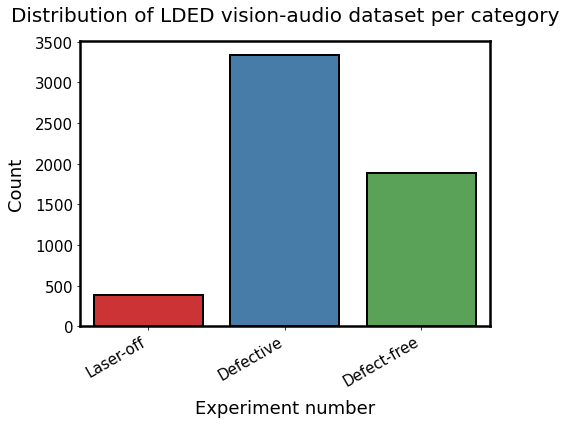

In [7]:
# sns.set(style="darkgrid")
plt.figure(figsize = (7,6))


ax = sns.countplot(x='class_v2', data = annotations_df, palette="Set1", linewidth=2,
                   edgecolor='k'); #palette='mako' 'Set2'
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
# ax = sns.countplot(y='label', data = df_dataset_denoised, palette="Set2");


ax.set_title('Distribution of LDED vision-audio dataset per category', fontsize = 20, pad=20);
ax.set_xlabel("Experiment number",fontsize=18, labelpad=10)
ax.set_ylabel("Count",fontsize=18, labelpad=10)
ax.tick_params(labelsize=15)

save_fig("dataset_2")

## Preparing Dataset and DataLoader

In [8]:
#------ transformation------
# instantiating our dataset object and create data loader
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=32
)

MFCCs = torchaudio.transforms.MFCC(sample_rate=SAMPLE_RATE,n_mfcc=20)

C:\Users\Asus\anaconda3\envs\working_primary\lib\site-packages\torchaudio\functional\functional.py:594: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [9]:
#------ data loader------
# create the dataset for all samples
audiodataset = LDEDAudioDataset(annotations_df,
                                AUDIO_DIR,
                                # mel_spectrogram,
                                MFCCs,
                                # spectral_centroid,
                                SAMPLE_RATE,
                                device)
print ("length of the total dataset:" + str(len(audiodataset)))

length of the total dataset:5615


### Dealing with Imbalanced dataset: stratified sampling

- Split the data into train, validation, and test set
- Train and Val are used for hyperparameter tuning
- Train set will go through some data augmentation

In [10]:
# Split the data into train and validation datasets
# train_annotations, val_annotations = train_test_split(annotations_df, test_size=0.2)
# create the StratifiedShuffleSplit object
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

# split the indices of annotations into train and test sets
train_indices, test_indices = next(sss.split(annotations_df, labels))

# split the data into train and test sets
train_annotations = annotations_df.iloc[train_indices, :]
test_annotations = annotations_df.iloc[test_indices, :]

# Create the train and validation datasets
train_dataset = LDEDAudioDataset(train_annotations,
                                 AUDIO_DIR,
                                 MFCCs,
                                 SAMPLE_RATE,
                                 device=device)

val_dataset = LDEDAudioDataset(test_annotations,
                               AUDIO_DIR,
                               MFCCs,
                               SAMPLE_RATE,
                               device=device)

### Create DataLoader using the dataset

In [11]:
# # Create train and val dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
# test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("length of the train dataset:" +  str(len(train_dataloader.dataset)))
print("length of the val dataset:" +  str(len(val_dataloader.dataset)))
# print("length of the test dataset:" +  str(len(test_dataloader.dataset)))

length of the train dataset:4492
length of the val dataset:1123


## Training the model

In [12]:
resume = False
start_epoch = 0
best_acc = 0

In [13]:
# -----Model---------------
print('==> Building model..')

net = MFCCCNN() 

net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
    print ("--- Using CUDA ---")

if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

loss_fn = nn.CrossEntropyLoss()
# Note: weight_decay in pytorch is L2 regularization
# optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE,
#                     momentum=0.9, weight_decay=5e-4)
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


# for epoch in range(start_epoch, start_epoch+EPOCHS):
    # train_single_epoch(net, epoch, train_dataloader, loss_fn, optimizer, device)
    # test_single_epoch(net, epoch, val_dataloader, loss_fn, device)
    # scheduler.step()

model, optimizer, (train_losses, valid_losses, train_accuracy, valid_accuracy) = training_loop(net, loss_fn, optimizer, train_dataloader, val_dataloader, EPOCHS, scheduler, device)

==> Building model..
--- Using CUDA ---

Epoch: 0
 [============================================>]  Step: 150ms | Tot: 25s500ms | Loss: 0.959 | Train Acc: 59.127% (2656/449 281/281 ====================>........................]  Step: 104ms | Tot: 11s539ms | Loss: 0.967 | Train Acc: 58.191% (1229/211 132/281 
 [============================================>]  Step: 66ms | Tot: 6s142ms | Loss: 0.953 | Test Acc: 59.394% (667/112 71/71  94ms | Tot: 182ms | Loss: 1.010 | Test Acc: 54.167% (26/4 3/71 

Epoch: 1
 [============================================>]  Step: 18ms | Tot: 6s753ms | Loss: 0.957 | Train Acc: 59.417% (2669/449 281/281 
 [============================================>]  Step: 5ms | Tot: 1s317ms | Loss: 0.953 | Test Acc: 59.394% (667/112 71/71  

Epoch: 2
 [============================================>]  Step: 18ms | Tot: 6s662ms | Loss: 0.957 | Train Acc: 59.439% (2670/449 281/281 
 [============================================>]  Step: 6ms | Tot: 1s346ms | Loss: 0.953 | Te

In [14]:
valid_accuracy

[59.394479073909174,
 59.394479073909174,
 59.394479073909174,
 59.394479073909174,
 59.394479073909174,
 59.394479073909174,
 59.394479073909174,
 59.394479073909174,
 59.394479073909174,
 59.394479073909174]

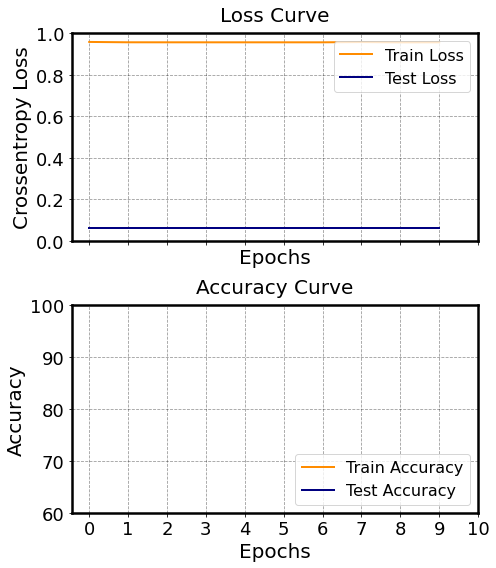

In [15]:
loss_acc_plot(train_losses, valid_losses, train_accuracy, valid_accuracy, 10, "Initial Training",
              interval=1, yloss_limit1=0, yloss_limit2=1.0, yacc_limit1=60, yacc_limit2=100)

In [16]:
get_accuracy(model, val_dataloader, device)

0.5939447907390917

Test Accuracy (cross-validation) for MFCC-CNN = 0.59394 ± 0.00163
micro-averaging AUC for MFCC-CNN = 0.65757 ± 0.00000


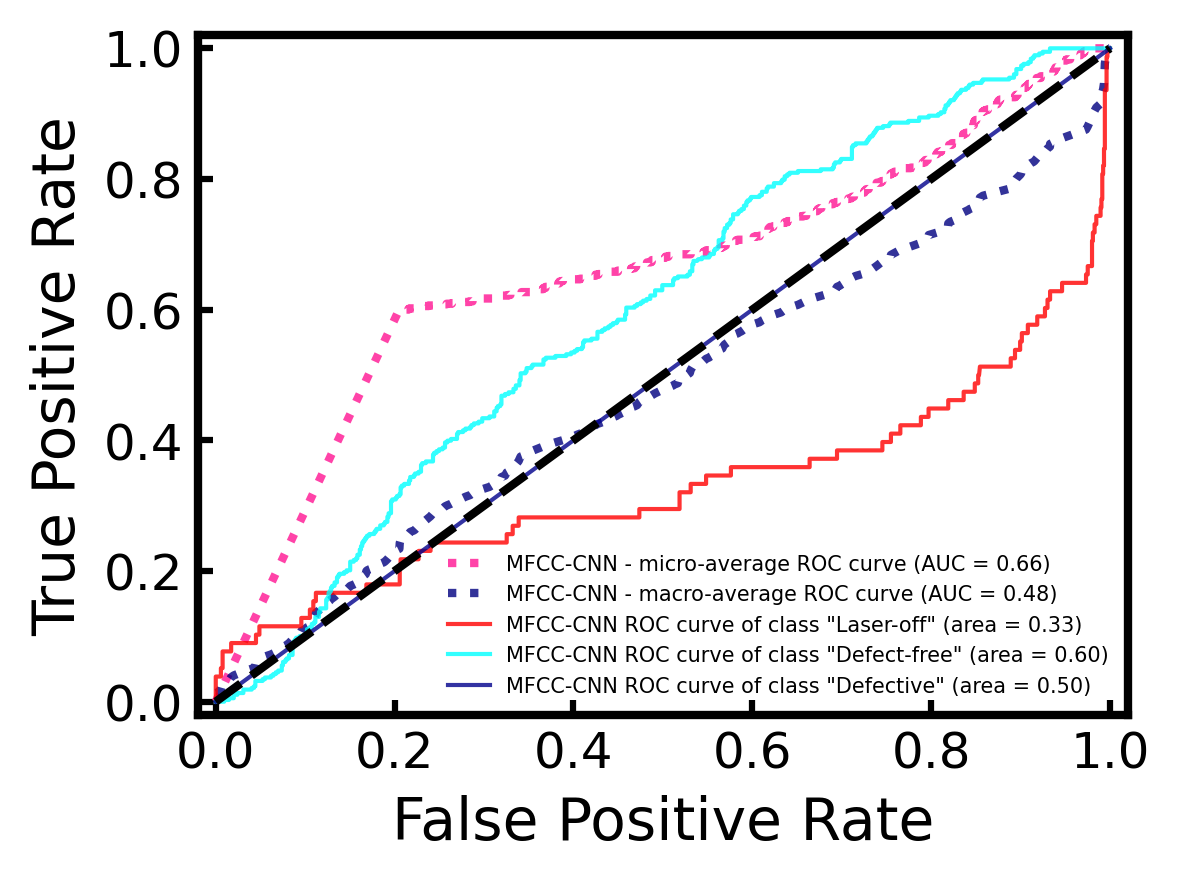

In [17]:
test_accuracy_mean, test_accuracy_std, auc_mean, auc_std = model_evaluation(model, val_dataloader, classes, device, classifier_name = "MFCC-CNN", signal_type = "denoised", seed=0)

In [18]:
yt, yp = class_report(model, val_dataloader, device, classes)

              precision    recall  f1-score   support

 Defect-free     0.0000    0.0000    0.0000       378
   Defective     0.5939    1.0000    0.7453       667
   Laser-off     0.0000    0.0000    0.0000        78

    accuracy                         0.5939      1123
   macro avg     0.1980    0.3333    0.2484      1123
weighted avg     0.3528    0.5939    0.4426      1123



C:\Users\Asus\anaconda3\envs\working_primary\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\anaconda3\envs\working_primary\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Asus\anaconda3\envs\working_primary\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

[[  0 378   0]
 [  0 667   0]
 [  0  78   0]]
Saving figure confusion_matrix(audio_based)


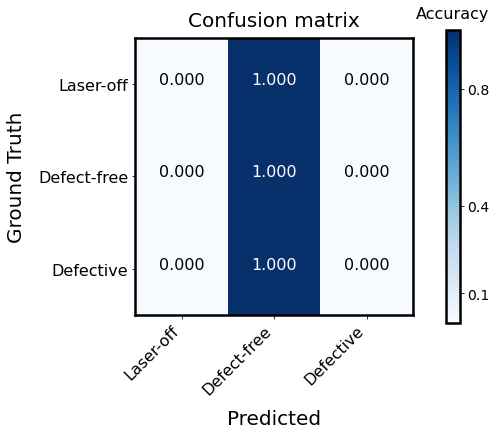

In [19]:
conf_matrix(yt, yp, classes)
save_fig("confusion_matrix(audio_based)")